 # DATA ANALYSIS


In [3]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

### Acquiring data

In [4]:
data = pd.read_csv("data/responses.csv")

Quick look at how the data is composed.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Columns: 150 entries, Music to House - block of flats
dtypes: float64(134), int64(5), object(11)
memory usage: 1.2+ MB


### Target variable

We try to determinate if a person has been smoking during a period of his life.

In [6]:
data["Smoker"] = data["Smoking"].map({
    "never smoked": 0, 
    "tried smoking": 0, 
    "former smoker": 1, 
    "current smoker": 1})
data.drop("Smoking", axis=1, inplace=True)

In [7]:
print("In our survey the smokers are the %.1f%% of the population." % (data["Smoker"].mean()*100))

In our survey the smokers are the 36.3% of the population.


How many missing values does our target variable have?

In [8]:
print("Number of missing values in target: %d" % data["Smoker"].isnull().sum())

Number of missing values in target: 8


In the rows with a missing value for the target variable "Smoker", which values are missing?

In [9]:
values_missing = dict()
for index, row in data[data["Smoker"].isnull()].iterrows():
    print("Index: %d - Missing: "% index, end=" ")
    for col in row[row.isnull()].index:
        print(col, end=" - ")
        if col in values_missing:
            values_missing[col] += 1
        else:
            values_missing[col] = 1
    print()
print("-" * 40)
for key in sorted(values_missing, key=values_missing.get, reverse=True):
    print("%s: %d" % (key, values_missing[key]))

Index: 130 - Missing:  Documentary - Alcohol - Smoker - 
Index: 149 - Missing:  Smoker - 
Index: 525 - Missing:  Fun with friends - Friends versus money - Hypochondria - Smoker - 
Index: 567 - Missing:  Documentary - Biology - Giving - Charity - Spending on looks - Smoker - 
Index: 629 - Missing:  Alcohol - Healthy eating - Smoker - 
Index: 708 - Missing:  Alcohol - Healthy eating - Smoker - 
Index: 763 - Missing:  Geography - Smoker - 
Index: 980 - Missing:  Passive sport - Smoker - 
----------------------------------------
Smoker: 8
Alcohol: 3
Documentary: 2
Healthy eating: 2
Fun with friends: 1
Friends versus money: 1
Hypochondria: 1
Biology: 1
Giving: 1
Charity: 1
Spending on looks: 1
Geography: 1
Passive sport: 1


Interesting to notice:
- Three people that chose to not indicate their smoking habits also avoided talking about alcohol consumption.
- Two of them also avoided talking about health habits.

We remove the rows with missing values for the target.

In [10]:
data = data.drop(data[data["Smoker"].isnull()].index)
print("Number of missing values in target: %d" % data["Smoker"].isnull().sum())

Number of missing values in target: 0


### Encoding of categorical variables

We transform categorical variables into numerical ones.

In [11]:
data.describe(exclude=np.number)

,Alcohol,Punctuality,Lying,Internet usage,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
count,1000,1000,1000,1002,996,999,1001,1000,998,998
unique,3,3,4,4,2,2,6,2,2,2
top,social drinker,i am always on time,sometimes,few hours a day,female,right handed,secondary school,no,city,block of flats
freq,658,396,544,737,589,899,617,747,702,590


In [12]:
data["Alcohol"] = data["Alcohol"].map({"never": 0, "social drinker": 1, "drink a lot": 2})

data["Punctuality"] = data["Punctuality"].map({"i am often early": 0, "i am always on time": 1, "i am often running late": 2})

data["Lying"] = data["Lying"].map({"never": 0, "sometimes": 1, "only to avoid hurting someone": 2, "everytime it suits me": 3})

data["Internet usage"] = data["Internet usage"].map({
    "no time at all": 0, 
    "less than an hour a day": 1, 
    "few hours a day": 2, 
    "most of the day": 3})

data["Female"] = data["Gender"].map({"male": 0, "female": 1})
data.drop("Gender", axis=1, inplace=True)

data["Right handed"] = data["Left - right handed"].map({"left handed": 0, "right handed": 1})
data.drop("Left - right handed", axis=1, inplace=True)

data["Education"] = data["Education"].map({
    "currently a primary school pupil": 0,
    "primary school": 1, 
    "secondary school": 2, 
    "college/bachelor degree": 3, 
    "masters degree": 4,
    "doctorate degree": 5})

data["Only child"] = data["Only child"].map({"no": 0, "yes": 1})

data["Living in a city"] = data["Village - town"].map({"village": 0, "city": 1})
data.drop("Village - town", axis=1, inplace=True)

data["Living in a flat"] = data["House - block of flats"].map({"house/bungalow": 0, "block of flats": 1})
data.drop("House - block of flats", axis=1, inplace=True)

### Correlation

What are the most heavily correlated features?

In [13]:
corr = data.corr()
ord_corr = dict()

# Saving heavily correlated features in a dictionary.
for row in range(corr.shape[0]):
    for col in range(corr.iloc[row].shape[0]):
        if abs(corr.iloc[row][col]) > 0.5 and row < col:
            key = corr.index[row] + " & " + corr.index[col]
            ord_corr[key] = corr.iloc[row][col]

for key in sorted(ord_corr, key=ord_corr.get, reverse=True):
    print("%s: %.3f" % (key, ord_corr[key]))

Biology & Medicine: 0.716
Height & Weight: 0.696
Biology & Chemistry: 0.690
Fantasy/Fairy tales & Animated: 0.676
Shopping & Shopping centres: 0.649
Chemistry & Medicine: 0.626
Age & Education: 0.618
Living in a city & Living in a flat: 0.603
Classical music & Opera: 0.595
Mathematics & Physics: 0.594
Snakes & Rats: 0.572
Life struggles & Female: 0.568
Metal or Hardrock & Punk: 0.545
Art exhibitions & Theatre: 0.535
Rock & Metal or Hardrock: 0.529
Religion & God: 0.511
Rock & Punk: 0.508
Shopping & Spending on looks: 0.507
Fear of public speaking & Public speaking: 0.507
Storm & Darkness: 0.507
Horror & Thriller: 0.506
Weight & Female: -0.644
Height & Female: -0.685


Which features are more correlated with our target variable?

In [14]:
corr_target = corr["Smoker"]
corr_target = corr_target.sort_values(ascending=False)
# Selection of the most correlated features.
relevant_features = corr_target[abs(corr_target)>0.1]
relevant_features

Smoker                    1.000000
Alcohol                   0.272063
Entertainment spending    0.185594
Cheating in school        0.174262
Hiphop, Rap               0.150029
Horror                    0.138637
Criminal damage           0.125700
Number of friends         0.119906
Spending on looks         0.117810
Age                       0.106776
Comedy                   -0.105114
God                      -0.105399
Classical music          -0.107466
Chemistry                -0.107610
Thinking ahead           -0.113683
Workaholism              -0.118797
Mathematics              -0.121718
Parents' advice          -0.129236
Finances                 -0.173211
Name: Smoker, dtype: float64

We can observe that 'Alcohol' has the highest correlation value (0.27).

#### An odd fact

While looking at these numbers, I noticed something odd. It is popular knowledge that men are usually more inclined to smoking than women, but this does not show in our dataset.

In [15]:
corr_target['Female']

0.02263756948527801

Actually, considering both positive and negative coefficients, 'Female' is only the 121st highest correlated feature! 

In [16]:
abs_corr_target = corr_target.abs().sort_values(ascending=False)
abs_corr_target.index.get_loc("Female")

121

After some research, I found out that in Slovakia, the country where the survey that generated the dataset took place, [39.7%](https://tradingeconomics.com/slovakia/smoking-prevalence-males-percent-of-adults-wb-data.html) of the men were smokers during 2015, while only [17.6%](https://tradingeconomics.com/slovakia/smoking-prevalence-females-percent-of-adults-wb-data.html) of females were smokers.

Are those percentages respected in our dataset?

In [17]:
smokers_by_gender = data.groupby("Female").mean()["Smoker"]
print("In our dataset %.1f%% of men are smokers." % (smokers_by_gender[0]*100))
print("In our dataset %.1f%% of women are smokers." % (smokers_by_gender[1]*100))

In our dataset 35.1% of men are smokers.
In our dataset 37.4% of women are smokers.


In our dataset 35.1% of the men are smokers, which is slightly below the national average, but okay given that some people may have lied.

It is utterly striking to notice that 37.3% of the women that took the survey affirmed to be smokers, a number that is higher than the men's one and more than double than the one reported as the national average!

This may be due to the limited size of the sample. It is a shame because an higher correlation between this feature and the target one could have greatly helped the tuning of our models.

# Missing values

Let's check how many missing values are in the data set and how can we deal with them.

In [18]:
data_na = round((data.isnull().sum() / len(data)) * 100, 3)
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"Missing": data.isnull().sum(),  "%": data_na}).sort_values(by="%", ascending=False)[:30]
missing_data.head(10)

,Missing,%
Weight,20,1.996
Height,20,1.996
Passive sport,14,1.397
Chemistry,10,0.998
Punk,8,0.798
Theatre,8,0.798
Latino,8,0.798
Geography,8,0.798
Alternative,7,0.699
Age,7,0.699


Text(0.5, 1.0, 'Top Variables for % of Missing Values')

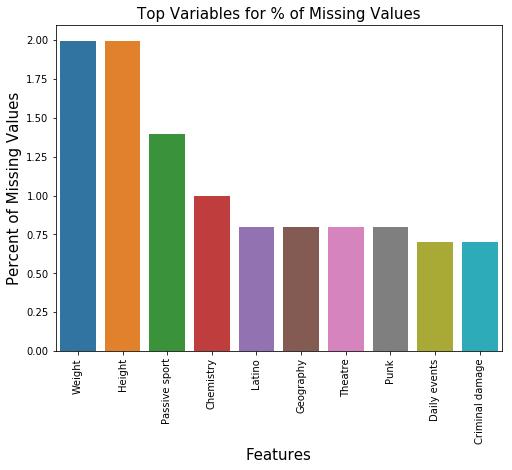

In [19]:
f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index[:10], y=data_na[:10])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Top Variables for % of Missing Values', fontsize=15)

In [20]:
corr_weight = corr["Weight"].sort_values(ascending=False)
imp_corr_weight = corr_weight[corr_weight.abs() > 0.5]
imp_corr_weight

Weight    1.000000
Height    0.695696
Female   -0.644266
Name: Weight, dtype: float64

In [21]:
# Filling missing value of Weight with the median weight of similar rows according to Height and Female
index_NaN_weight = list(data["Weight"][data["Weight"].isnull()].index)

for i in index_NaN_weight:
    weight_med = data["Weight"].median()
    weight_pred = data["Weight"][((data['Height'] == data.iloc[i]["Height"]) & (data['Female'] == data.iloc[i]["Female"]))].median()
    if not np.isnan(weight_pred) :
        data['Weight'].iloc[i] = weight_pred
    else:
        data['Weight'].iloc[i] = weight_med

C:\Users\Shakk\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
# Filling missing value of Height with the median weight of similar rows according to Weight and Female
index_NaN_height = list(data["Height"][data["Height"].isnull()].index)

for i in index_NaN_height:
    height_med = data["Height"].median()
    height_pred = data["Height"][((data['Weight'] == data.iloc[i]["Weight"]) & (data['Female'] == data.iloc[i]["Female"]))].median()
    if not np.isnan(height_pred) :
        data['Height'].iloc[i] = height_pred
    else:
        data['Height'].iloc[i] = height_med

We substitute the remaining missing values with the most frequent value in their column.

In [23]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [24]:
data = pd.DataFrame(data=imp.fit_transform(data), columns=data.columns, index=data.index)
print("Missing values: %d" % (data.isnull().sum().sum()))

Missing values: 0


### Binning of continuous variables

In [25]:
# Continuous variable bins
data['AgeBin'] = pd.cut(data['Age'], 5)
data['HeightBin'] = pd.qcut(data['Height'].astype(int), 5)
data['WeightBin'] = pd.qcut(data['Weight'].astype(int), 5)

# Convert objects to categories
data['Age'] = LabelEncoder().fit_transform(data['AgeBin'])
data['Height'] = LabelEncoder().fit_transform(data['HeightBin'])
data['Weight'] = LabelEncoder().fit_transform(data['WeightBin'])

# Drop unnecessary features
drop_features = ['AgeBin', 'HeightBin', 'WeightBin']
data = data.drop(drop_features, axis=1)

We keep only the data with the features heavily correlated with "Smoker".

In [26]:
relevant_data = data[relevant_features.index]

Now we save the cleaned data into a file, ready to be used for modeling.

In [27]:
relevant_data.to_csv("data/clean_relevant_data.csv", index=False)
data.to_csv("data/clean_data.csv", index=False)